# Analyze IGF2BP2 RIP in circles
- iteration 6: only 1 replicate
- iteration 10: 3 replicates

# Basic Statistics

In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from matplotlib_venn import venn2


indir1 = '/home/hsher/scratch/circ_nextera_iter8/output/'
circ_quant_output = [os.path.join(indir1,f) for f in os.listdir(indir1) if f.endswith('.gtf')]

# the basic rar11 recipe
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('HEK_rar11')]

indir2 = '/home/hsher/scratch/circ_nextera_iter11/output/'
circ_quant_output += [os.path.join(indir2,f) for f in os.listdir(indir2) if f.endswith('.gtf')]


In [2]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [3]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']
for fname in circ_quant_output:
    
    
    name = os.path.basename(fname).replace('.gtf', '')
    
    names.append(name)

    circ_df, stat = read_ciri_gtf(fname)

    circ_type_count.append(circ_df['circ_type'].value_counts())

    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))




    mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()

stats_df = pd.concat(stats, axis = 1).T
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

stats_df = stats_df.drop_duplicates('##Sample').set_index('##Sample')
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']


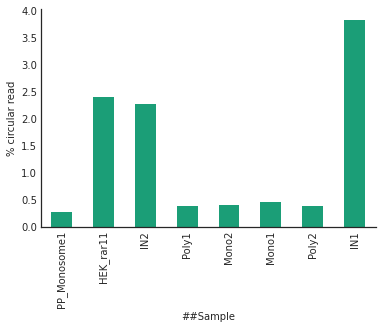

In [4]:

(stats_df['frac_circular']*100).plot.bar()
plt.ylabel('% circular read')
sns.despine()

In [5]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

In [6]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

In [7]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

In [8]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

In [9]:
bsj_cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6
fsj_cpm=fsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

# Types of circular RNA detected

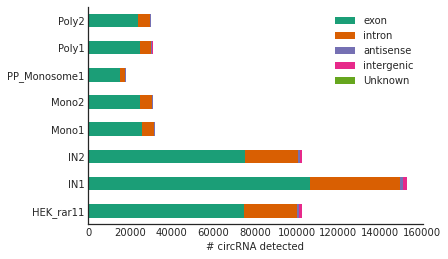

In [10]:
counts.T.sort_index().plot.barh(stacked = True)
plt.xlabel('# circRNA detected')
sns.despine()

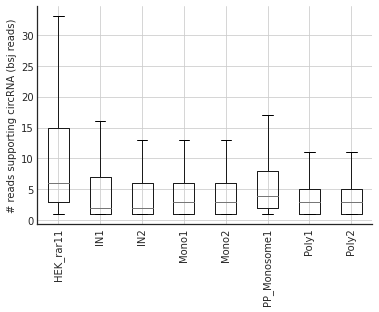

In [11]:
bsj.reindex(sorted(bsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting circRNA (bsj reads)')
sns.despine()

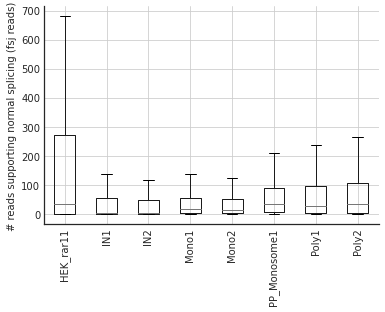

In [12]:
fsj.reindex(sorted(fsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting normal splicing (fsj reads)')
sns.despine()

Text(0, 0.5, '(BSJ+1)/(FSJ+1)')

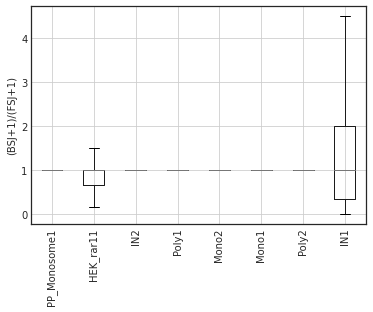

In [13]:
((bsj.fillna(0)+1)/(fsj.fillna(0)+1)).boxplot(showfliers=False, rot = 90)
plt.ylabel('(BSJ+1)/(FSJ+1)')

# CircRIP output

In [14]:
def read_circRIP_outputs(indir, sample1, sample2):
    rip_output = pd.read_csv(Path(indir)/'circRIP/'/f'{sample1}_vs_{sample2}',
    sep = '\t', names = ['circ_id', 'gene', 'BSJs in IP',
            'circRNA in Input','CPM in IP','CPM in Input',
            'IP/Input ratio','p-value', 'status'],
                comment = '>'
            )
    # annotation
    circ_df, stat = read_ciri_gtf(Path(indir)/f'{sample1}.gtf')
    rip_output = rip_output.merge(circ_df, left_on = 'circ_id', right_on = 'circ_id')
    return rip_output

In [15]:
# monosome_output1_1 = read_circRIP_outputs(indir1, 'PP_Monosome1', 'PP_Input1')
# monosome_output1_2 = read_circRIP_outputs(indir1, 'PP_Monosome2', 'PP_Input2')
# polysome_output1_1 = read_circRIP_outputs(indir1, 'PP_Polysome1', 'PP_Input1')
# polysome_output1_2 = read_circRIP_outputs(indir1, 'PP_Polysome2', 'PP_Input2')
# monosome_output2_1 = read_circRIP_outputs(indir2, 'Mono1', 'IN1')
# monosome_output2_2 = read_circRIP_outputs(indir2, 'Mono2', 'IN2')
# polysome_output2_1 = read_circRIP_outputs(indir2, 'Poly1', 'IN1')
# polysome_output2_2 = read_circRIP_outputs(indir2, 'Poly2', 'IN2')

In [16]:
# all_rip_outputs = [monosome_output1_1, monosome_output1_2, polysome_output1_1, polysome_output1_2,
#                   monosome_output2_1, monosome_output2_2, polysome_output2_1, polysome_output2_2]

In [17]:
# f, axes = plt.subplots(4,2, sharex = True, sharey = True)

# for output, ax in zip(all_rip_outputs, axes.flatten()):
#     output['p-value'].hist(ax=ax, density = True)
    
# plt.xlabel('pvalue')
# plt.ylabel('#circRNA')
# sns.despine()

In [18]:
# cnt = polysome_output2_1.groupby(by = ['circ_type', 'status']).count()['circ_id'].unstack()
# cnt.T.plot.bar(stacked = True)
# plt.ylabel('# circular RNA')

In [19]:
# for output in all_rip_outputs:
#     print(
#         output.loc[output['gene'].str.contains('ZNF609'), ['circ_id', 'status', 'p-value']]
#     )

# My outputs

In [20]:
annot2 = pd.read_csv(Path(indir2)/'count_table.tsv', sep = '\t', index_col = 0)
my_monosome_output2_1 = pd.read_csv(Path(indir2) /'RIP/Mono1.IN1.csv', index_col = 0)
my_monosome_output2_2 = pd.read_csv(Path(indir2) /'RIP/Mono2.IN2.csv', index_col = 0)
my_polysome_output2_1 = pd.read_csv(Path(indir2) /'RIP/Poly1.IN1.csv', index_col = 0)
my_polysome_output2_2 = pd.read_csv(Path(indir2) /'RIP/Poly2.IN2.csv', index_col = 0)

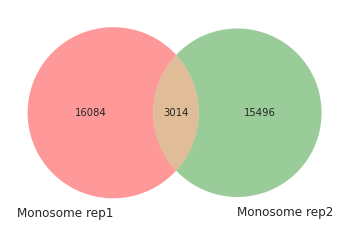

In [21]:
FDR_threshold = 0.2

venn2([set(my_monosome_output2_1.loc[my_monosome_output2_1['FDR']<FDR_threshold, 'circ_id']),
           set(my_monosome_output2_2.loc[my_monosome_output2_2['FDR']<FDR_threshold, 'circ_id'])
          ],set_labels = ['Monosome rep1', 'Monosome rep2'])


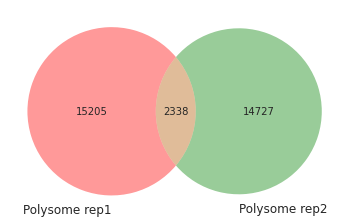

In [22]:
FDR_threshold = 0.2

venn2([set(my_polysome_output2_1.loc[my_polysome_output2_1['FDR']<FDR_threshold, 'circ_id']),
           set(my_polysome_output2_2.loc[my_polysome_output2_2['FDR']<FDR_threshold, 'circ_id'])
          ],set_labels = ['Polysome rep1', 'Polysome rep2'])


In [23]:
monosome_reproducible = set(my_monosome_output2_1.loc[my_monosome_output2_1['FDR']<FDR_threshold, 'circ_id']
                           ).intersection(set(my_monosome_output2_2.loc[my_monosome_output2_2['FDR']<FDR_threshold, 'circ_id'])
                                         )
polysome_reproducible = set(my_polysome_output2_1.loc[my_polysome_output2_1['FDR']<FDR_threshold, 'circ_id']
                           ).intersection(set(my_polysome_output2_2.loc[my_polysome_output2_2['FDR']<FDR_threshold, 'circ_id'])
                                         )
        

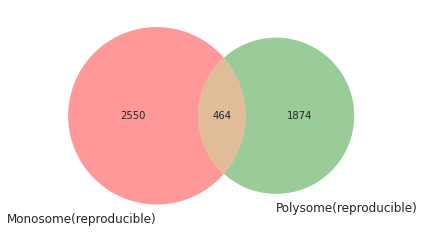

In [24]:
venn2([monosome_reproducible,
           polysome_reproducible
          ],set_labels = ['Monosome(reproducible)', 'Polysome(reproducible)'])


In [25]:
annot2['is_Monosome']=annot2['circ_id'].isin(monosome_reproducible)
annot2['is_Polysome']=annot2['circ_id'].isin(polysome_reproducible)

In [26]:
tested = set(my_monosome_output2_1.loc[my_monosome_output2_1['tested'], 'circ_id']).intersection(
    set(my_monosome_output2_2.loc[my_monosome_output2_2['tested'], 'circ_id'])).intersection(
    set(my_polysome_output2_1.loc[my_polysome_output2_1['tested'], 'circ_id'])).intersection(
    set(my_polysome_output2_2.loc[my_polysome_output2_2['tested'], 'circ_id']))

In [27]:
len(tested)

22023

In [28]:
circtype_counts = annot2.loc[annot2['circ_id'].isin(tested)].groupby(by = ['is_Monosome', 'is_Polysome'])['circ_type'].value_counts(
).unstack().fillna(0)

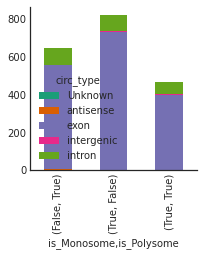

In [29]:
circtype_counts.iloc[1:,].plot.bar(stacked = True, figsize = (3,3))
sns.despine()

In [30]:
circtype_counts.div(circtype_counts.sum(axis = 1), axis = 0)

circ_type                Unknown  antisense      exon  intergenic    intron
is_Monosome is_Polysome                                                    
False       False         0.0001   0.001891  0.880986    0.004978  0.112046
            True          0.0000   0.009288  0.851393    0.004644  0.134675
True        False         0.0000   0.002430  0.883354    0.007290  0.106926
            True          0.0000   0.002155  0.859914    0.004310  0.133621

In [31]:
pd.concat([circtype_counts.loc[:, circtype_counts.columns!='exon'].sum(axis = 1),
          circtype_counts['exon']], axis = 1)

0     exon
is_Monosome is_Polysome                 
False       False        2391.0  17699.0
            True           96.0    550.0
True        False          96.0    727.0
            True           65.0    399.0

In [32]:
from scipy.stats import fisher_exact,chisquare
def testing(df):
    ''' perform fisher exact or chisq given contingency table'''
    if df.shape != (2,2):
        # some outcomes are unobserved
        print(df.shape)
        print('no binding is observed in')
        return 1, np.nan
    if df.le(5).any().any():
        odds_ratio, pvalue = fisher_exact(df)
    else:
        chi, pvalue = chisquare(df.loc[True], (df.loc[True].sum())*df.loc[False].div(df.loc[False].sum()))
        odds_ratio = (df.loc[True, True]/df.loc[True, False])/(df.loc[False, True]/df.loc[False, False])
    return pvalue, odds_ratio

In [33]:
annot2.loc[annot2['gene_name']=='ZNF609']

,seqname,source,feature,start,end,strand,frame,circ_id,circ_type,gene_id,...,BSJ-Poly2,BSJ-IN1,FSJ-IN2,FSJ-Poly1,FSJ-Mono2,FSJ-Mono1,FSJ-Poly2,FSJ-IN1,is_Monosome,is_Polysome
79609,chr15,CIRIquant,circRNA,64499293.0,64500166.0,+,.,chr15:64499293|64500166,exon,ENSG00000180357.9,...,39.0,24.0,20.0,50.0,24.0,0.0,33.0,0.0,False,False
79610,chr15,CIRIquant,circRNA,64616185.0,64623052.0,+,.,chr15:64616185|64623052,intron,ENSG00000180357.9,...,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,False,False
79611,chr15,CIRIquant,circRNA,64622827.0,64623052.0,+,.,chr15:64622827|64623052,exon,ENSG00000180357.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
79613,chr15,CIRIquant,circRNA,64669033.0,64670433.0,+,.,chr15:64669033|64670433,intron,ENSG00000180357.9,...,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,False,False
23893,chr15,CIRIquant,circRNA,64469700.0,64469983.0,+,.,chr15:64469700|64469983,intron,ENSG00000180357.9,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,False,False
23895,chr15,CIRIquant,circRNA,64499293.0,64504346.0,+,.,chr15:64499293|64504346,intron,ENSG00000180357.9,...,0.0,1.0,0.0,0.0,32.0,0.0,0.0,38.0,False,False
24633,chr15,CIRIquant,circRNA,64673916.0,64678482.0,+,.,chr15:64673916|64678482,exon,ENSG00000180357.9,...,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,False,False
119497,chr15,CIRIquant,circRNA,64495840.0,64500166.0,+,.,chr15:64495840|64500166,intron,ENSG00000180357.9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,43.0,False,False
119499,chr15,CIRIquant,circRNA,64499293.0,64503595.0,+,.,chr15:64499293|64503595,intron,ENSG00000180357.9,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
119502,chr15,CIRIquant,circRNA,64622827.0,64626632.0,+,.,chr15:64622827|64626632,intron,ENSG00000180357.9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,False,False


## Compare with published results

In [34]:
transcirc = pd.read_csv('transcirc_metadata.tsv', sep = '\t')
transcirc['circ_id']=transcirc['chrom']+':'+transcirc['start'].astype(str)+'|'+transcirc['end'].astype(str)
transcirc.drop_duplicates(subset = ['circ_id'], inplace = True)

In [35]:
transcirc.head()

,TransCirc_ID,xref,species,gene,strand,gene_id,chrom,start,end,evidences_num,evidences_score,MS_Qvalue,m6A,RP/RP,TIS,ORF,IRES,Peptide composition,MS,circ_id
0,TC-hsa-NOC2L_0001,circAtlas:hsa-NOC2L_0004,Homo sapiens,NOC2L,-,ENSG00000188976.10,chr1,945057,945653,3,1.937380,NaN,0.0,0.000000,0.0,1.0,0.158810,0.778570,0.0,chr1:945057|945653
1,TC-hsa-KLHL17_0001,circAtlas:hsa-KLHL17_0001,Homo sapiens,KLHL17,+,ENSG00000187961.13,chr1,961826,962047,2,1.741661,NaN,0.0,0.000000,0.0,1.0,0.000000,0.741661,0.0,chr1:961826|962047
2,TC-hsa-ISG15_0003,circAtlas:hsa-ISG15_0004,Homo sapiens,ISG15,+,ENSG00000187608.8,chr1,1008194,1009370,3,1.771572,NaN,0.0,0.000000,0.0,1.0,0.067883,0.703689,0.0,chr1:1008194|1009370
3,TC-hsa-AGRN_0003,circAtlas:hsa-AGRN_0013; circpedia2:HSA_CIRCpe...,Homo sapiens,AGRN,+,ENSG00000188157.13,chr1,1046397,1046957,3,1.818838,NaN,0.0,0.000000,0.0,1.0,0.017630,0.801208,0.0,chr1:1046397|1046957
4,TC-hsa-SDF4_0002,circAtlas:hsa-SDF4_0001; circBase:hsa_circ_000...,Homo sapiens,SDF4,-,ENSG00000078808.16,chr1,1223244,1223968,4,2.220746,NaN,0.0,0.333333,0.0,1.0,0.126974,0.760439,0.0,chr1:1223244|1223968


In [36]:
all_data = pd.merge(transcirc, annot2[['circ_id', 'is_Monosome', 'is_Polysome']]
         , left_on = 'circ_id'
         , right_on = 'circ_id')
         

Text(0, 0.5, '# Evidence Supporting Translation')

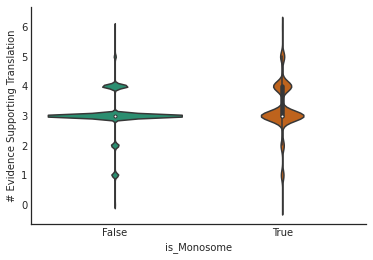

In [37]:
sns.violinplot(data = all_data, x = 'is_Monosome', y= 'evidences_num',
             )
sns.despine()
plt.ylabel('# Evidence Supporting Translation')


In [38]:
evidence_num_df = all_data.groupby(by = ['is_Monosome', 'is_Polysome'])['evidences_num'].value_counts().unstack().fillna(0)

In [39]:
all_data['4_or_more_evidence']=all_data['evidences_num']>=4

In [40]:
pv_mono, odds_mono = testing(all_data.groupby(by = ['is_Monosome', '4_or_more_evidence']).count()['circ_id'].unstack())

In [41]:
pv_poly, odds_poly = testing(all_data.groupby(by = ['is_Polysome', '4_or_more_evidence']).count()['circ_id'].unstack())

([<matplotlib.axis.XTick at 0x2b6595c3b040>,
 [Text(0, 0, 'Monosome'), Text(1, 0, 'Polysome')])

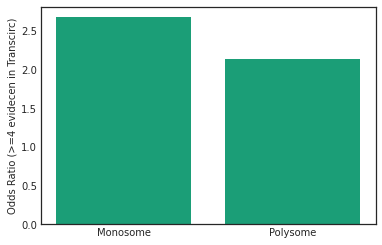

In [42]:
plt.bar(x = [0,1], height = [odds_mono, odds_poly])
plt.ylabel('Odds Ratio (>=4 evidecen in Transcirc)')
plt.xticks([0,1], ['Monosome', 'Polysome'])

In [43]:
all_data.columns

Index(['TransCirc_ID', 'xref', 'species', 'gene', 'strand', 'gene_id', 'chrom',
       'start', 'end', 'evidences_num', 'evidences_score', 'MS_Qvalue', 'm6A',
       'RP/RP', 'TIS', 'ORF', 'IRES', 'Peptide composition', 'MS', 'circ_id',
       'is_Monosome', 'is_Polysome', '4_or_more_evidence'],
      dtype='object')

In [44]:
m6A_num_df = all_data.groupby(by = ['is_Monosome', 'is_Polysome'])['m6A'].value_counts().unstack().fillna(0)

In [45]:
m6A_num_df

m6A                        0.0    1.0
is_Monosome is_Polysome              
False       False        89757  10416
            True          1291    164
True        False         1686    344
            True           346     65

In [61]:
all_data['m6A'] = (all_data['m6A']>0)
testing(all_data.groupby(by = ['is_Polysome', 'm6A']).count()['circ_id'].unstack())

(0.014093719767748711, 1.1888443476029458)

In [47]:

testing(all_data.groupby(by = ['is_Monosome', 'm6A']).count()['circ_id'].unstack())

(1.0167310547877957e-24, 1.732145408808776)

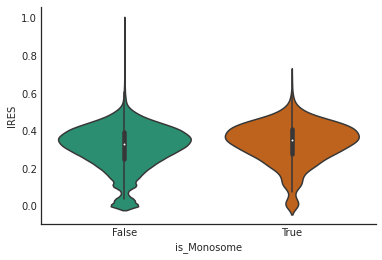

In [48]:
sns.violinplot(data = all_data, x = 'is_Monosome', y= 'IRES',
             )
sns.despine()


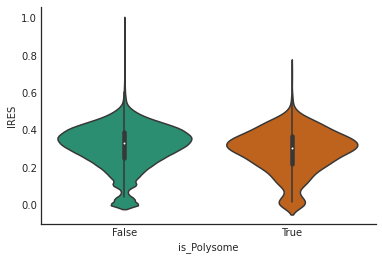

In [49]:
sns.violinplot(data = all_data, x = 'is_Polysome', y= 'IRES',
             )
sns.despine()


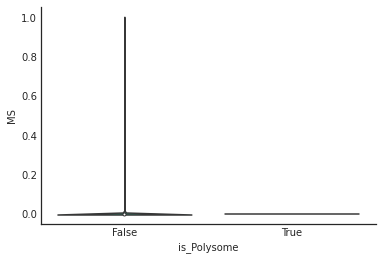

In [50]:
sns.violinplot(data = all_data, x = 'is_Polysome', y= 'MS',
             )
sns.despine()


In [51]:
all_data['TIS'] = all_data['TIS'].map({0:False, 1:True})
testing(all_data.groupby(by = ['is_Polysome', 'TIS']).count()['circ_id'].unstack())

(2.243921222225942e-06, 1.5764107642546954)

In [52]:
testing(all_data.groupby(by = ['is_Monosome', 'TIS']).count()['circ_id'].unstack())

(5.67865551887677e-14, 1.8107938726239585)

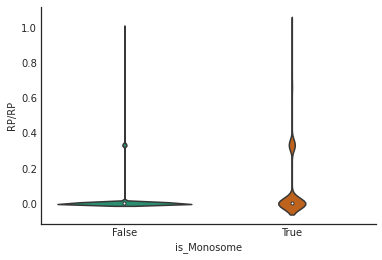

In [53]:
sns.violinplot(data = all_data, x = 'is_Monosome', y= 'RP/RP',
             )
sns.despine()


In [54]:
all_data['is_RP']=all_data['RP/RP']>0
testing(all_data.groupby(by = ['is_Monosome', 'is_RP']).count()['circ_id'].unstack())

(0.0, 6.593787248054214)

In [55]:
all_data['is_RP'].value_counts()

False    100052
True       4017
Name: is_RP, dtype: int64

In [56]:
all_data['is_RP']=all_data['RP/RP']>0
testing(all_data.groupby(by = ['is_Monosome', 'is_RP']).count()['circ_id'].unstack())

(0.0, 6.593787248054214)

In [57]:
all_data['is_RP']=all_data['RP/RP']>0
testing(all_data.groupby(by = ['is_Polysome', 'is_RP']).count()['circ_id'].unstack())

(8.802757355693098e-198, 5.293563278810393)

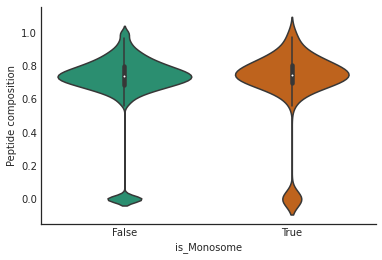

In [58]:
sns.violinplot(data = all_data, x = 'is_Monosome', y= 'Peptide composition',
             )
sns.despine()


In [59]:
all_data['ORF'] = all_data['ORF'].map({0:False, 1:True})
testing(all_data.groupby(by = ['is_Polysome', 'ORF']).count()['circ_id'].unstack())

(0.17276961674499733, 0.8746769196704176)

In [60]:
testing(all_data.groupby(by = ['is_Monosome', 'ORF']).count()['circ_id'].unstack())

(2.931837148935068e-06, 0.6956426730984328)